# Exploration 4 - 멋진 인공지능 작사가 만들기 🎵

### Step 1. 라이브러리 불러오기

In [2]:
import os, re 
import numpy as np
import tensorflow as tf

### Step 2. 데이터 읽어오기
- glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하기

In [3]:
import glob

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()  # 행(줄) 단위로 담기
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


### Step 3. 데이터 정제하기
<!-- 
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요! -->

토큰화하기: 정규표현식(Regex)을 이용 `import re`
1. 문장 부호 양쪽에 공백을 추가 
2.모든 문자들을 소문자로 변환  
3.특수문자들은 모두 제거 

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기

In [5]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    
    # 토큰의 개수가 15개를 넘어가는 문장은 제외합니다.
    if len(preprocessed_sentence.split()) > 15: continue
    corpus.append(preprocessed_sentence)
    
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

벡터화(vectorize)하기
- tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 데이터를 숫자로 변환. 
- 숫자로 변환된 데이터: 텐서(tensor)

####  단어장의 크기는 12,000 이상 으로 설정
#### 문장 길이 15로 제한: maxlen 사용

In [6]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer(단어장)를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다 - 문자 데이터 입력 받아 리스트 형태로 반환
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor(시퀀스)로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15) # maxlen 사용하여 문장길이 제한 
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2967 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  118 ...    0    0    0]
 [   2  258  194 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f22e52c6fd0>


표준정규분포에서 95% 확률 이내로 포함하게 하는 식 사용: mean + 2*std
- 원하는 문장 길이가 나오지 않아 사용하지 않기로 함...pass

In [7]:
# # 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# # 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# def tokenize(corpus):
#     # 12000단어를 기억할 수 있는 tokenizer(단어장)를 만들겁니다
#     # 우리는 이미 문장을 정제했으니 filters가 필요없어요
#     # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(
#         num_words=12000,  
#         filters=' ',
#         oov_token="<unk>"
#     )
#     # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다 - 문자 데이터 입력 받아 리스트 형태로 반환
#     tokenizer.fit_on_texts(corpus)
    
#     # 준비한 tokenizer를 이용해 corpus를 Tensor(시퀀스)로 변환합니다
#     tensor = tokenizer.texts_to_sequences(corpus)   
    
#     # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
#     # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
#     # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
#     tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

#     total_data_text = list(tensor)
#     num_tokens = [len(tokens) for tokens in total_data_text]
#     max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
#     maxlen = int(max_tokens)
#     # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
#     # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen) # maxlen 사용하여 문장길이 제한 
    
#     print(tensor,tokenizer)
#     return tensor, tokenizer

# tensor, tokenizer = tokenize(corpus)

In [7]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Now I've heard there was a secret chord
That David played, and it pleased the Lord
But you don't really care for music, do you?
It goes like this
The fourth, the fifth
The minor fall, the major lift
The baffled king composing Hallelujah Hallelujah
Hallelujah
Hallelujah
Hallelujah Your faith was strong but you needed proof


생성된 텐서 데이터 5행까지 출력해보기 

In [8]:
# tokenizer에 구축된 단어 사전의 인덱스 출력
print(tensor[:5, :]) 

[[   2   50    4   95  303   62   53    9  946 6263    3    0    0    0
     0]
 [   2   15 2967  871    5    8   11 5739    6  374    3    0    0    0
     0]
 [   2   33    7   40   16  164  288   28  333    5   48    7   46    3
     0]
 [   2   11  335   23   41    3    0    0    0    0    0    0    0    0
     0]
 [   2    6 4486    5    6 2039    3    0    0    0    0    0    0    0
     0]]


정제된 후 텐서, 문장 크기 출력해보기

In [9]:
print(len(tensor), len(corpus))

156013 156013


단어 사전이 어떻게 구축되었는지 확인해보기

In [10]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


 생성된 텐서를 소스와 타겟으로 분리하기

In [11]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6263    3    0    0    0]
[  50    4   95  303   62   53    9  946 6263    3    0    0    0    0]


### Step 4. 평가 데이터셋 분리
- 총 데이터의 20% 를 평가 데이터셋으로 사용

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                    tgt_input, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [14]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


텐서로 생성된 데이터를 이용해 tf.data.Dataset 객체 생성하기
- shuffle(), batch() 등 다양한 데이터셋 관련 기능 포함

In [15]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
LYRIC_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# train 데이터셋 만들기 --> 자세히 알수록 중요함
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(train_dataset)

# test 데이터셋 만들기
test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(test_dataset)

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>


### Step 5. 인공지능 만들기

- 모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요! (Loss는 아래 제시된 Loss 함수를 그대로 사용!)

model에 데이터를 아주 조금 태워 보기

In [20]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 1024  # 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 데이터 양이 충분해야함
hidden_size = 2048   # 모델에 얼마나 많은 일꾼을 둘 것인가, 충분한 데이터가 주어져야 배가 산으로 가지 않음
lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [21]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
lyricist(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 5.01896939e-05,  3.29882430e-04, -5.51342819e-05, ...,
          6.67699089e-04,  2.40379144e-04,  3.65873857e-04],
        [ 2.08770871e-05,  5.62457659e-04,  2.93285611e-05, ...,
          1.11232232e-03,  2.79974745e-04,  9.37446079e-04],
        [-1.05041559e-04,  7.88373174e-04, -6.80911980e-05, ...,
          1.29787659e-03,  3.00088104e-05,  1.20658195e-03],
        ...,
        [ 2.53458600e-03,  3.29848239e-03, -9.48704197e-04, ...,
          8.36240302e-04, -3.36623378e-03,  1.54756824e-03],
        [ 3.27609177e-03,  3.70352971e-03, -1.22581411e-03, ...,
          3.96622519e-04, -4.16732393e-03,  1.42839004e-03],
        [ 4.00099205e-03,  4.07682732e-03, -1.47672335e-03, ...,
         -3.24660869e-05, -4.85852314e-03,  1.36008870e-03]],

       [[ 5.01896939e-05,  3.29882430e-04, -5.51342819e-05, ...,
          6.67699089e-04,  2.40379144e-04,  3.65873857e-04],
        [ 7.79621405e-05,  7.59693212e-04,  1

- 모델의 파라미터 사이즈 측정 --> 대략 29million
- 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없

In [22]:
lyricist.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  12289024  
_________________________________________________________________
lstm_2 (LSTM)                multiple                  25174016  
_________________________________________________________________
lstm_3 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense_1 (Dense)              multiple                  24590049  
Total params: 95,615,713
Trainable params: 95,615,713
Non-trainable params: 0
_________________________________________________________________


In [23]:
optimizer = tf.keras.optimizers.Adam()

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

lyricist.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
history = lyricist.fit(train_dataset, 
                       validation_data=test_dataset, 
                       epochs=10, 
                       verbose=1)

Epoch 1/10
487/487 [==============================] - 277s 564ms/step - loss: 3.2157 - accuracy: 0.5077 - val_loss: 2.8535 - val_accuracy: 0.5328
Epoch 2/10
487/487 [==============================] - 275s 565ms/step - loss: 2.6651 - accuracy: 0.5489 - val_loss: 2.5948 - val_accuracy: 0.5573
Epoch 3/10
487/487 [==============================] - 276s 566ms/step - loss: 2.3311 - accuracy: 0.5808 - val_loss: 2.4130 - val_accuracy: 0.5825
Epoch 4/10
487/487 [==============================] - 276s 567ms/step - loss: 2.0040 - accuracy: 0.6212 - val_loss: 2.2793 - val_accuracy: 0.6068
Epoch 5/10
487/487 [==============================] - 276s 567ms/step - loss: 1.7003 - accuracy: 0.6686 - val_loss: 2.1865 - val_accuracy: 0.6291
Epoch 6/10
487/487 [==============================] - 276s 567ms/step - loss: 1.4427 - accuracy: 0.7156 - val_loss: 2.1376 - val_accuracy: 0.6480
Epoch 7/10
487/487 [==============================] - 277s 568ms/step - loss: 1.2433 - accuracy: 0.7558 - val_loss: 2.1199 -

loss와 accuracy 그래프로 그려보기

In [26]:
import matplotlib.pyplot as plt

def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

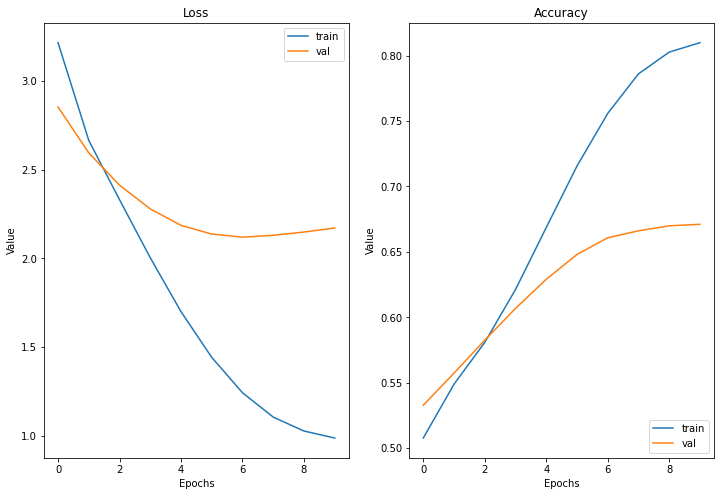

In [27]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

모델이 생성한 가사 한 줄 출력

In [28]:
def generate_text(lyricist, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = lyricist(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [29]:
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '

### 결과 Report

- 생성된 문장: '<start> i love you , i m not gonna crack <end> '
- 최종 val_loss: 2.1717 

## 회고

- 이번 프로젝트는 만드는 내내 조금 재미있었습니다. 인간의 영역이라고만 생각했던 '창조'를 AI가 학습을 통해 어떻게든 해낸다는게 대견하기도 하고 뿌듯하네요. 그러나 여러 문제점들이 발생하기는 했습니다...  

- 토큰화할 때 정규표현식(Regex)을 이용해야 했는데 사용하는 것에 익숙하지가 않아서 조금 어려웠습니다. 자연어처리를 깊이있게 연구하려면 공부가 더 필요할 것 같다는 생각입니다. 

- train data, test data를 분리했는데도 train_dataset, test_dataset을 만들어서 lyricist.fit(train_dataset, test_dataset, epochs=10)에 넣어서 모델을 학습시켜야 되는지 완전히 이해하지는 못한 것 같습니다... 아직 해결되지 않은 부분입니다. 

- 문장 길이를 15로 제한하는 것에 대해서 왜 if len(preprocessed_sentence.split()) > 15: continue:을 했는데 또 maxlen=15로 지정해야하는지 의문이 생겨 한참을 고민하고 찾아보다가 알아내는 과정에서 많이 배운 것 같습니다. 만약 앞에 있는 if문을 추가해주지 않으면 한 문장에 15개 단어가 넘는 것들이 걸러지는 것이 아니라 15개 단어에서 잘려서 나올 것이기 때문에 둘 다 필요하다는 것을 알게되었습니다. 

`total_data_text = list(tensor)
num_tokens = [len(tokens) for tokens in total_data_text]
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)`
- max_len을 이런식으로 표준정규분포에서 95% 확률 이내로 포함하게 하는 식(mean + 2*std)을 사용해서 지정해줄 수 있는데, 이렇게 통계학에서 배웠던 지식을 활용해 여러 방법들을 생각해보는건 재미있었습니다. 

- 갈길이 먼 것 같긴 하지만 .... 앞으로도 열심히 배우겠습니다 !!! 💘💘💘